In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import torch
import torchvision
from torchvision.transforms import transforms
import torch.nn.functional as F
import torch.nn as nn

In [4]:
class BaseBlock(nn.Module):
  expansion=1
  def __init__(self,in_planes,planes,stride=1,dimens=None):
    super(BaseBlock,self).__init__()
    """
    Declaring convolutional layers with Batch norms
    """
    self.conv1 = nn.Conv2d(in_planes,planes,stride = stride,kernel_size=3,padding=1)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(planes)
    self.dimens = dimens

  def forward(self,x):
    res = x
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))

    if self.dimens is not None:
      res = self.dimens(res)

    out +=res 
    out = F.relu(out)
    return out



In [5]:
class BottleNeck(nn.Module):
  expansion=4
  def __init__(self,in_planes,planes,stride=1,dimens=None):
  
    super(BottleNeck,self).__init__()
    self.conv1 = nn.Conv2d(in_planes,planes,stride=1,kernel_size=1)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes,planes*self.expansion,kernel_size=1)
    self.bn3 = nn.BatchNorm2d(planes*self.expansion)
    self.dimens = dimens



  def forward(self,x):
    res = x
    out =F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))

    if self.dimens is not None:
      res = self.dimens(res)
    out +=res
    out =F.relu(out)
    return out


In [6]:
class ResNet(nn.Module):
  def __init__(self,block,num_layers,classes=10):
    super(ResNet,self).__init__()
    self.in_planes = 64
    self.conv1 = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1)
    self.bn1 = nn.BatchNorm2d(64)

    self.layer1 = self._make_layer(block,64,num_layers[0],stride=1)
    self.layer2 = self._make_layer(block,128,num_layers[1],stride=2)
    self.layer3 = self._make_layer(block,256,num_layers[2],stride=2)
    self.layer4 = self._make_layer(block,512,num_layers[3],stride=2)
    self.averagepool = nn.AvgPool2d(kernel_size=4,stride=1)
    self.fc = nn.Linear(512*block.expansion,classes)


  def _make_layer(self,block,planes,num_layers,stride=1):
    dimens = None
    if stride !=1 or planes != self.in_planes*block.expansion:
      dimens = nn.Sequential(
          nn.Conv2d(self.in_planes,planes*block.expansion,kernel_size=1,stride=stride),
          nn.BatchNorm2d(planes*block.expansion)
      )

    netlayers = []
    netlayers.append(block(self.in_planes,planes,stride=stride,dimens=dimens))
    self.in_planes = planes*block.expansion
    for i in range(1,num_layers):
      netlayers.append(block(self.in_planes,planes))
      self.in_planes = planes*block.expansion
    return nn.Sequential(*netlayers)


  def forward(self,x):
    x = F.relu(self.bn1(self.conv1(x)))

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = F.avg_pool2d(x,4)
    x = x.view(x.size(0),-1)#convert from 3d to 2d
    x = self.fc(x)
    return x


In [7]:
def resnet18():
    layers=[2,2,2,2]
    model = ResNet(BottleNeck,layers)
    return model

In [8]:
model=resnet18()

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [10]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )

#Load train and test set:
train = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(train,batch_size=128,shuffle=True)

test = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(test,batch_size=128,shuffle=False)


0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [12]:
train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(trainloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [13]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(testloader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 



In [14]:
epochs=10
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


  0%|          | 0/391 [00:00<?, ?it/s]


Epoch : 1



100%|██████████| 391/391 [01:27<00:00,  4.48it/s]

  3%|▎         | 2/79 [00:00<00:06, 12.55it/s]

Train Loss: 1.650 | Accuracy: 38.674



100%|██████████| 79/79 [00:06<00:00, 13.03it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.409 | Accuracy: 48.630

Epoch : 2



100%|██████████| 391/391 [01:26<00:00,  4.53it/s]

  3%|▎         | 2/79 [00:00<00:05, 13.29it/s]

Train Loss: 1.222 | Accuracy: 55.590



100%|██████████| 79/79 [00:06<00:00, 12.88it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.205 | Accuracy: 56.530

Epoch : 3



100%|██████████| 391/391 [01:26<00:00,  4.53it/s]

  3%|▎         | 2/79 [00:00<00:06, 11.11it/s]

Train Loss: 0.994 | Accuracy: 64.386



100%|██████████| 79/79 [00:06<00:00, 12.84it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.988 | Accuracy: 64.330

Epoch : 4



100%|██████████| 391/391 [01:26<00:00,  4.53it/s]

  3%|▎         | 2/79 [00:00<00:05, 13.37it/s]

Train Loss: 0.806 | Accuracy: 71.436



100%|██████████| 79/79 [00:06<00:00, 13.09it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.941 | Accuracy: 66.710

Epoch : 5



100%|██████████| 391/391 [01:25<00:00,  4.55it/s]

  3%|▎         | 2/79 [00:00<00:05, 13.21it/s]

Train Loss: 0.636 | Accuracy: 77.590



100%|██████████| 79/79 [00:06<00:00, 12.85it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.033 | Accuracy: 65.190

Epoch : 6



100%|██████████| 391/391 [01:25<00:00,  4.55it/s]

  3%|▎         | 2/79 [00:00<00:05, 13.15it/s]

Train Loss: 0.477 | Accuracy: 83.420



100%|██████████| 79/79 [00:06<00:00, 12.61it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.958 | Accuracy: 68.170

Epoch : 7



100%|██████████| 391/391 [01:25<00:00,  4.55it/s]

  3%|▎         | 2/79 [00:00<00:05, 13.32it/s]

Train Loss: 0.329 | Accuracy: 89.054



100%|██████████| 79/79 [00:06<00:00, 12.83it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.131 | Accuracy: 66.700

Epoch : 8



100%|██████████| 391/391 [01:25<00:00,  4.55it/s]

  3%|▎         | 2/79 [00:00<00:05, 13.20it/s]

Train Loss: 0.199 | Accuracy: 93.644



100%|██████████| 79/79 [00:06<00:00, 13.02it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.183 | Accuracy: 67.650

Epoch : 9



100%|██████████| 391/391 [01:25<00:00,  4.55it/s]

  3%|▎         | 2/79 [00:00<00:05, 13.30it/s]

Train Loss: 0.119 | Accuracy: 96.476



100%|██████████| 79/79 [00:05<00:00, 13.17it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.236 | Accuracy: 68.100

Epoch : 10



100%|██████████| 391/391 [01:25<00:00,  4.55it/s]

  3%|▎         | 2/79 [00:00<00:05, 13.44it/s]

Train Loss: 0.073 | Accuracy: 97.868



100%|██████████| 79/79 [00:06<00:00, 13.01it/s]

Test Loss: 1.244 | Accuracy: 69.580


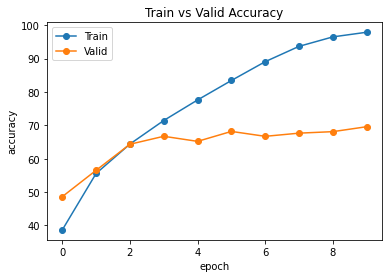

In [15]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

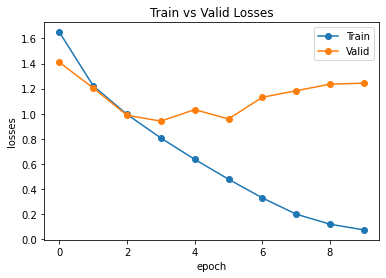

In [16]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [18]:
res18_train_losses=train_losses
res18_eval_losses=eval_losses
res18_train_accu=train_accu
res18_eval_accu=eval_accu

In [24]:
def resnet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BottleNeck,layers)
    return model

In [25]:
model=resnet34()

In [26]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(trainloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    
    
    

In [27]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(testloader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 



In [28]:
epochs=10
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


  0%|          | 0/391 [00:00<?, ?it/s]


Epoch : 1



100%|██████████| 391/391 [02:06<00:00,  3.09it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.93it/s]

Train Loss: 1.747 | Accuracy: 34.952



100%|██████████| 79/79 [00:09<00:00,  8.65it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.452 | Accuracy: 46.940

Epoch : 2



100%|██████████| 391/391 [02:06<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.75it/s]

Train Loss: 1.316 | Accuracy: 51.714



100%|██████████| 79/79 [00:09<00:00,  8.64it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.223 | Accuracy: 55.540

Epoch : 3



100%|██████████| 391/391 [02:06<00:00,  3.09it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.88it/s]

Train Loss: 1.101 | Accuracy: 60.456



100%|██████████| 79/79 [00:09<00:00,  8.51it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.083 | Accuracy: 60.750

Epoch : 4



100%|██████████| 391/391 [02:06<00:00,  3.09it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.67it/s]

Train Loss: 0.922 | Accuracy: 67.210



100%|██████████| 79/79 [00:09<00:00,  8.48it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.058 | Accuracy: 62.470

Epoch : 5



100%|██████████| 391/391 [02:06<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.87it/s]

Train Loss: 0.746 | Accuracy: 73.576



100%|██████████| 79/79 [00:09<00:00,  8.67it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.980 | Accuracy: 65.320

Epoch : 6



100%|██████████| 391/391 [02:06<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:09,  8.66it/s]

Train Loss: 0.600 | Accuracy: 78.558



100%|██████████| 79/79 [00:09<00:00,  8.66it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.990 | Accuracy: 66.930

Epoch : 7



100%|██████████| 391/391 [02:06<00:00,  3.09it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.85it/s]

Train Loss: 0.461 | Accuracy: 83.802



100%|██████████| 79/79 [00:09<00:00,  8.66it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.964 | Accuracy: 68.630

Epoch : 8



100%|██████████| 391/391 [02:06<00:00,  3.09it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.95it/s]

Train Loss: 0.327 | Accuracy: 88.552



100%|██████████| 79/79 [00:09<00:00,  8.68it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.089 | Accuracy: 68.200

Epoch : 9



100%|██████████| 391/391 [02:06<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:09,  8.65it/s]

Train Loss: 0.238 | Accuracy: 91.718



100%|██████████| 79/79 [00:09<00:00,  8.62it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.315 | Accuracy: 67.020

Epoch : 10



100%|██████████| 391/391 [02:06<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.73it/s]

Train Loss: 0.171 | Accuracy: 94.122



100%|██████████| 79/79 [00:09<00:00,  8.59it/s]

Test Loss: 1.355 | Accuracy: 67.140


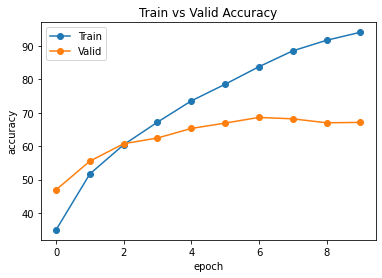

In [29]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

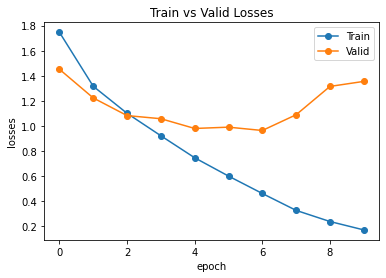

In [30]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [32]:
res34_train_losses=train_losses
res34_eval_losses=eval_losses
res34_train_accu=train_accu
res34_eval_accu=eval_accu

In [34]:
def resnet50():
    layers=[3, 4, 6, 3]
    model = ResNet(BottleNeck,layers)
    return model

In [35]:
model=resnet50()


In [36]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(trainloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    
    
    

In [37]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(testloader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 



In [42]:
epochs=10
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


  0%|          | 0/391 [00:00<?, ?it/s]


Epoch : 1



100%|██████████| 391/391 [02:06<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.79it/s]

Train Loss: 1.773 | Accuracy: 34.282



100%|██████████| 79/79 [00:09<00:00,  8.62it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.453 | Accuracy: 46.680

Epoch : 2



100%|██████████| 391/391 [02:06<00:00,  3.09it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.86it/s]

Train Loss: 1.326 | Accuracy: 51.550



100%|██████████| 79/79 [00:09<00:00,  8.54it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.265 | Accuracy: 53.020

Epoch : 3



100%|██████████| 391/391 [02:06<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.86it/s]

Train Loss: 1.103 | Accuracy: 60.180



100%|██████████| 79/79 [00:09<00:00,  8.43it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.061 | Accuracy: 61.490

Epoch : 4



100%|██████████| 391/391 [02:06<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:09,  8.00it/s]

Train Loss: 0.914 | Accuracy: 67.384



100%|██████████| 79/79 [00:09<00:00,  8.42it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.029 | Accuracy: 63.730

Epoch : 5



100%|██████████| 391/391 [02:06<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.80it/s]

Train Loss: 0.752 | Accuracy: 73.500



100%|██████████| 79/79 [00:09<00:00,  8.50it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.879 | Accuracy: 69.040

Epoch : 6



100%|██████████| 391/391 [02:07<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:09,  8.66it/s]

Train Loss: 0.607 | Accuracy: 78.670



100%|██████████| 79/79 [00:09<00:00,  8.68it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.877 | Accuracy: 69.830

Epoch : 7



100%|██████████| 391/391 [02:07<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:09,  8.54it/s]

Train Loss: 0.464 | Accuracy: 83.802



100%|██████████| 79/79 [00:09<00:00,  8.59it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.997 | Accuracy: 68.640

Epoch : 8



100%|██████████| 391/391 [02:07<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.68it/s]

Train Loss: 0.344 | Accuracy: 87.968



100%|██████████| 79/79 [00:09<00:00,  8.61it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.000 | Accuracy: 70.320

Epoch : 9



100%|██████████| 391/391 [02:06<00:00,  3.08it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.72it/s]

Train Loss: 0.244 | Accuracy: 91.596



100%|██████████| 79/79 [00:09<00:00,  8.64it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.010 | Accuracy: 71.380

Epoch : 10



100%|██████████| 391/391 [02:06<00:00,  3.09it/s]

  1%|▏         | 1/79 [00:00<00:08,  8.88it/s]

Train Loss: 0.180 | Accuracy: 93.730



100%|██████████| 79/79 [00:09<00:00,  8.66it/s]

Test Loss: 1.194 | Accuracy: 69.930


In [38]:
res101_train_losses=[0.7381574827082017,
 0.6561662262053136,
 0.5982737085398506,
 0.526521349044712,
 0.43481628429096986,
 0.32969389108898084,
 0.22886353782604418,
 0.1562712992186589,
 0.12048650840702264,
 0.09438201098624245]


In [39]:
res101_eval_losses=[0.7966794960106476,
 0.8187391531618335,
 0.7679197543029543,
 0.7888273521314694,
 0.8301582600496993,
 0.9007718087751654,
 1.042142296139198,
 1.1651468465599832,
 1.2080454222763641,
 1.2977669442756266]

In [40]:
res101_train_accu=[73.79, 76.854, 78.962, 81.706, 84.878, 88.574, 92.366, 94.68, 95.878, 96.806]

In [41]:
res101_eval_accu =[72.01, 72.78, 74.09, 74.23, 73.95, 74.23, 73.17, 73.43, 73.62, 72.98]

In [43]:
res50_train_losses=train_losses
res50_eval_losses=eval_losses
res50_train_accu=train_accu
res50_eval_accu=eval_accu

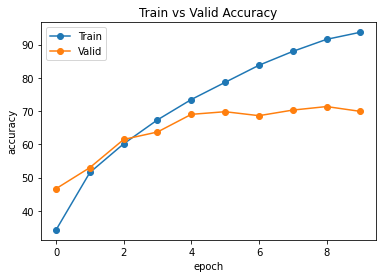

In [44]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

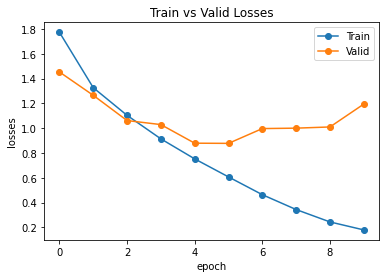

In [45]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

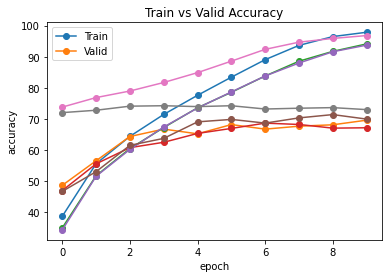

In [46]:
#plot accuracy

plt.plot(res18_train_accu,'-o')
plt.plot(res18_eval_accu,'-o')
plt.plot(res34_train_accu,'-o')
plt.plot(res34_eval_accu,'-o')
plt.plot(res50_train_accu,'-o')
plt.plot(res50_eval_accu,'-o')
plt.plot(res101_train_accu,'-o')
plt.plot(res101_eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

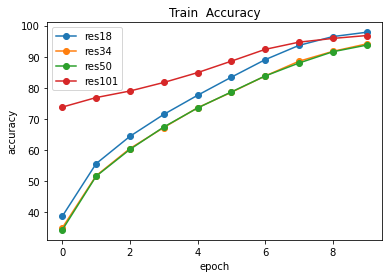

In [49]:
plt.plot(res18_train_accu,'-o')
plt.plot(res34_train_accu,'-o')
plt.plot(res50_train_accu,'-o')
plt.plot(res101_train_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['res18','res34','res50','res101'])
plt.title('Train  Accuracy')

plt.show()

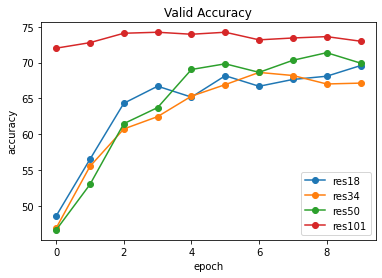

In [48]:
plt.plot(res18_eval_accu,'-o')
plt.plot(res34_eval_accu,'-o')
plt.plot(res50_eval_accu,'-o')
plt.plot(res101_eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['res18','res34','res50','res101'])
plt.title('Valid Accuracy')

plt.show()

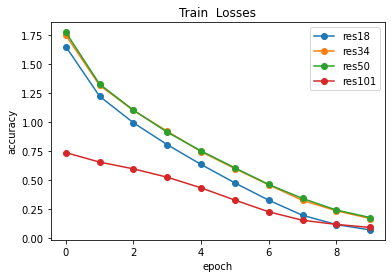

In [50]:
plt.plot(res18_train_losses,'-o')
plt.plot(res34_train_losses,'-o')
plt.plot(res50_train_losses,'-o')
plt.plot(res101_train_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['res18','res34','res50','res101'])
plt.title('Train  Losses')

plt.show()

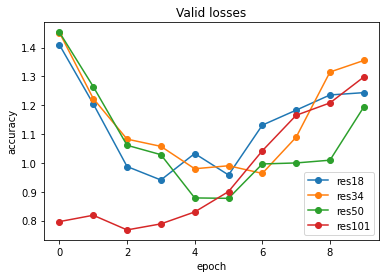

In [51]:
plt.plot(res18_eval_losses,'-o')
plt.plot(res34_eval_losses,'-o')
plt.plot(res50_eval_losses,'-o')
plt.plot(res101_eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['res18','res34','res50','res101'])
plt.title('Valid losses')

plt.show()

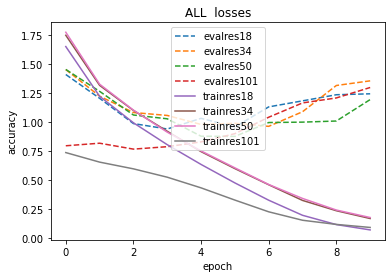

In [55]:
plt.plot(res18_eval_losses,'--')
plt.plot(res34_eval_losses,'--')
plt.plot(res50_eval_losses,'--')
plt.plot(res101_eval_losses,'--')
plt.plot(res18_train_losses,'-')
plt.plot(res34_train_losses,'-')
plt.plot(res50_train_losses,'-')
plt.plot(res101_train_losses,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['evalres18','evalres34','evalres50','evalres101','trainres18','trainres34','trainres50','trainres101'])
plt.title('ALL  losses')

plt.show()

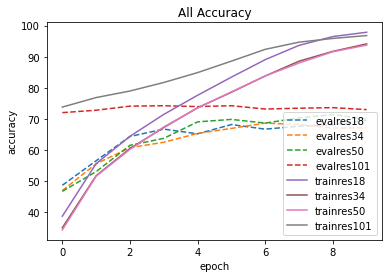

In [56]:
plt.plot(res18_eval_accu,'--')
plt.plot(res34_eval_accu,'--')
plt.plot(res50_eval_accu,'--')
plt.plot(res101_eval_accu,'--')

plt.plot(res18_train_accu,'-')
plt.plot(res34_train_accu,'-')
plt.plot(res50_train_accu,'-')
plt.plot(res101_train_accu,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['evalres18','evalres34','evalres50','evalres101','trainres18','trainres34','trainres50','trainres101'])
plt.title('All Accuracy')

plt.show()